# MIDTERM: PARAMETER ESTIMATION WITH SOLUTIONS

# Questions

In this homework, you will do a parameter estimation for
BioModels model 957, a model of COVID.

1. (10 pts) **Acquire the Model**. Create a roadrunner instance of the model and print the antimony representation of the model in an output cell.
1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model. Use start time 0 and end time of 5.
   1. (10 pts) Create a function ``generateNoisyData``: Creates noisy versions of the simulation floating species. Inputs are antimony model and standard deviation of noise; outputs are SBstoat.NamedTimeseries.
   1. (5 pts) Create and save in a global variable synthetic data for standard deviations of 0, 0.1, 0.5, 1.0, 2.0.
   1. (5 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
1. (40 pts) **Experiment Infrastructure**. Implement the following functions. Feel free to use ``SBstoat`` or ``lmfit``.:
    1. (10 pts) ``getParameters``: Creates a list of ``SBstoat.Parameter`` (or ``lmfit.Parameter``) from a dictionary with keys of parameter names and values that are the values of parameters in the model. It also has arguments that indicate the range for the parameter (as a fraction of the parameter's true value) and the starting value.
    1. (30 pts) ``doFit``: Encapsulates the fitting and evaluation workflow. Inputs are: antimony model, standard deviation of noise, the fitting method, and fractions of the true value for: lower end of parameter search, starting value of parameter search, and upper end of parameter search; Outputs are: residual sum of squares of the fit and the number of function evaluations (see ``getFitterInfo`` in Helper Functions.  
1. (30 pts) **Experiments and Analysis**.
Use the experiment infrastructure to determine of effects of: standard deviation of noise,
search range, and search algorithm. You want to understand the impact on accuracy of parameter estimates and the time to do the parameter estimation. We will quantify accuracy in terms of residual sum of square, and time is in units of function evaluations.
    1. (10 pts) Plot the results. (16 plots.) All experiments should set the starting value of the searchto the lower end of the range.
        1. Use the data generated in Question 2.
        1. Use the search ranges lower_frc, upper_frc = (0.5, 2.0) and (0.25, 4.0)
        1. Use the search algorithms ``leastsquares`` and ``differential_evolution`` Construct plots as follows:
            1. x-axis: standard deviation
            2. y-axis: residual sum of squares, maximum estimation error, median estimation error, number of function evaluations (set getFitterInfo in Helpers)
            3. Do 2 plots; one for each combination of lower_frc, upper_frc.
    1. (20 pts) Answer the following questions. (5 pts for each correct answer)
       1. Which algorithm (leastsquares or differential_evolution) works best for these data and why?
       1. Why are the maximum error and median error higher for the search range (0.25, 4.0) compared with (0.5, 2.0)?
       1. Why does the residual sum of squares (RSSQ) increase with standard deviation?
       1. Why does do estimation errors (max_err and median_err) increase from standard deviation of 0 to non-zero standard deviations?


# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [ ]:
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [ ]:
!pip install -q tellurium
!pip install -q SBstoat

In [ ]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te

In [ ]:
# Python packages used in this chapter
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

# Midterm Code

// Created by libAntimony v2.13.4
function Rate_Law_for_Susceptible_to_Infected(beta, I, S)
  beta*I*S;
end

Rate_Law_for_Susceptible_to_Infected is "Rate Law for Susceptible_to_Infected"


model *Roda2020___SIR_model_of_COVID_19_spread_in_Wuhan()

  // Compartments and Species:
  compartment Wuhan;
  species Susceptible in Wuhan, Infected in Wuhan, Recovered in Wuhan, Confirmed in Wuhan;

  // Reactions:
  Susceptible_to_Infected: Susceptible => Infected; Wuhan*Rate_Law_for_Susceptible_to_Infected(beta, Infected, Susceptible);
  Infected_to_Recovered: Infected => Recovered; Wuhan*mu*Infected;
  Infected_to_Confirmed: Infected => Confirmed; Wuhan*rho*Infected;

  // Species initializations:
  Susceptible = 5999755;
  Infected = 60;
  Recovered = 0;
  Confirmed = 0;

  // Compartment initializations:
  Wuhan = 1;

  // Variable initializations:
  beta = 2.09e-07;
  rho = 0.909;
  mu = 0.1;

  // Other declarations:
  const Wuhan, beta, rho, mu;

  // Unit definitions:
  unit length = me

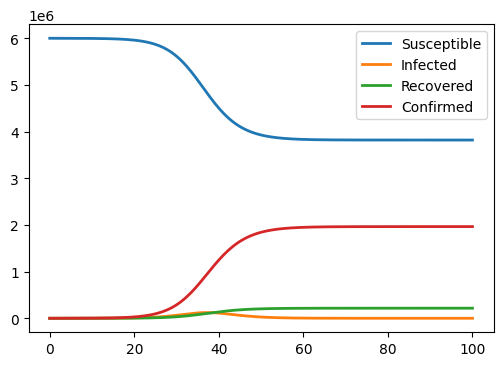

In [ ]:
r = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2008110001/6/Roda2020.xml")

print(r.getAntimony())

r.simulate(0,100,300, ['Time', 'Susceptible', 'Infected', 'Recovered', 'Confirmed'])



# Print the data
print(r.getSimulationData())

r.plot()


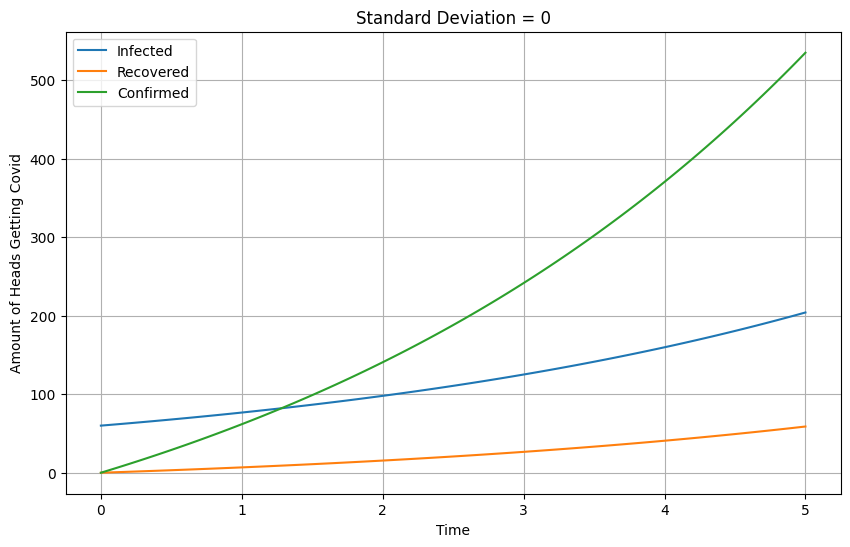

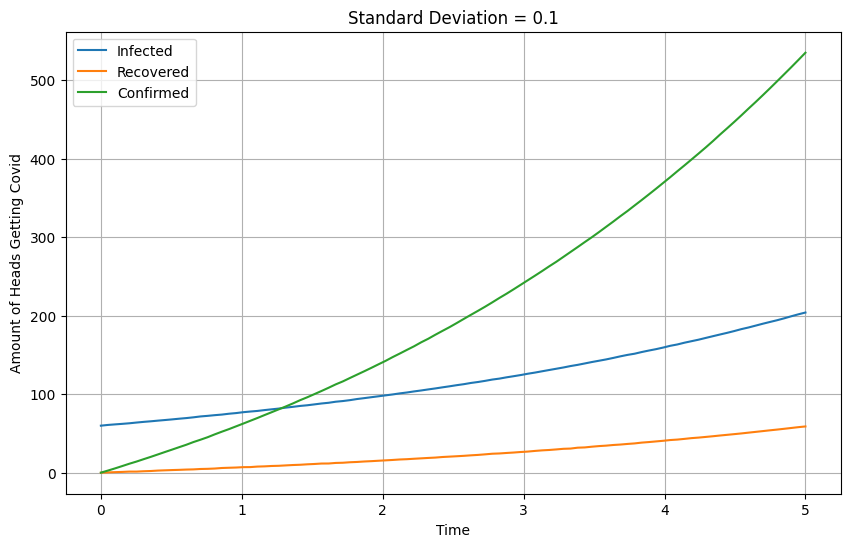

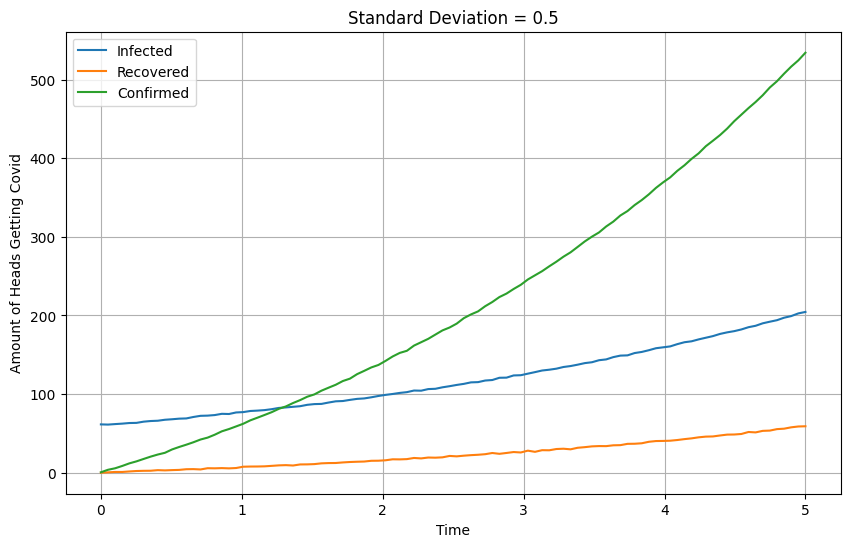

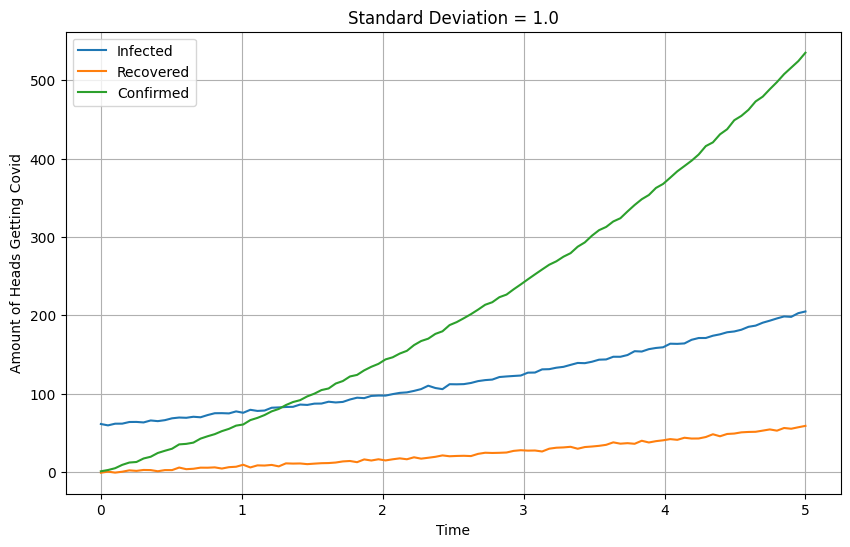

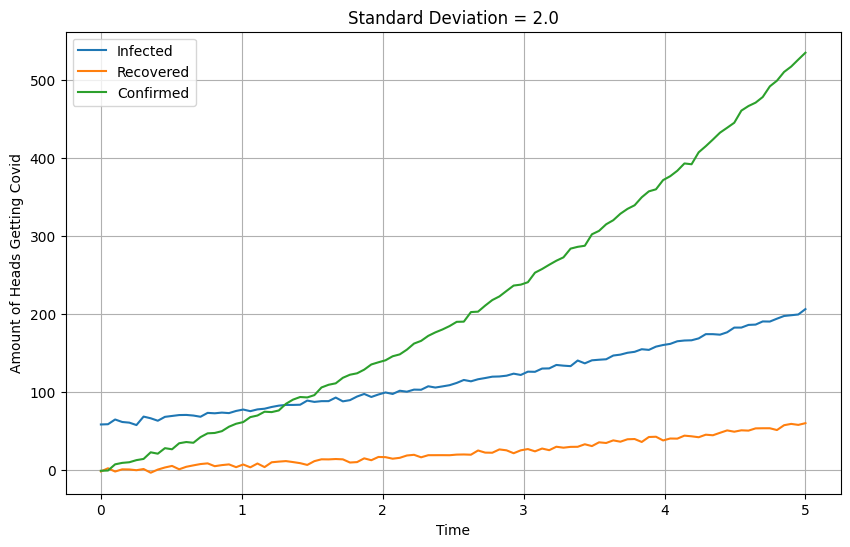

In [ ]:

synthetic_data = {}


model = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2008110001/6/Roda2020.xml")


# Standard deviations to consider
std_devs = [0, 0.1, 0.5, 1.0, 2.0]

def generateNoisyData(model, std_dev):
    model.reset()
    result = model.simulate(0, 5, 100, ['Time', 'Susceptible', 'Infected', 'Recovered', 'Confirmed'])
    time = result[:, 0]
    species_data = result[:, 1:]
    noise = np.random.normal(0, std_dev, species_data.shape)
    noisy_data = species_data + noise
    noisy_result = np.column_stack((time, noisy_data))

    # Convert the noisy_result to a NamedTimeseries object
    noisy_timeseries = SBstoat.NamedTimeseries(array=noisy_result, colnames=['Time', 'Susceptible', 'Infected', 'Recovered', 'Confirmed'])

    return noisy_timeseries

# Generate and store the noisy data for each standard deviation
for std_dev in std_devs:
    model.reset()
    noisy_data = generateNoisyData(model, std_dev)
    synthetic_data[std_dev] = noisy_data

# Function to plot the data
def plot_data(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    #plt.plot(data['Time'], data['Susceptible'], label='Susceptible')  #Uncomment this line to see Suseptible in the Graphs. Left commented out in submission to show that nosie works.
    plt.plot(data['Time'], data['Infected'], label='Infected')
    plt.plot(data['Time'], data['Recovered'], label='Recovered')
    plt.plot(data['Time'], data['Confirmed'], label='Confirmed')
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

std_devs_to_plot = [0, 0.1, 0.5, 1.0, 2.0]

for std_dev in std_devs_to_plot:
    data = synthetic_data[std_dev]
    title = f'Standard Deviation = {std_dev}'
    ylabel = 'Amount of Heads Getting Covid'
    plot_data(data, title, ylabel)



In [ ]:
FitterInfo = collections.namedtuple("FitterInfo", "rssq num_eval fitter max_err median_err")

def getFitterInfo(fitter):
    df = (fitter.residualsTS.to_dataframe()**2)
    rssq = df.sum().sum()
    # Find the number of function evaluations
    report_stg = fitter.reportFit()
    pos = report_stg.index("function evals")
    stg = report_stg[pos:]
    start_pos = stg.index("=") + 1
    end_pos = stg.index("\n")
    num_eval = int(stg[start_pos:end_pos])
    # Get statistics on the fit
    fitter.roadrunnerModel.resetAll()
    parameter_value_dct = getParameterValueDct(fitter.roadrunnerModel.getAntimony())
    errs = []
    for key, value in fitter.params.valuesdict().items():
        err = np.abs(value - parameter_value_dct[key])/parameter_value_dct[key]
        errs.append(err)
    max_err = max(errs)
    median_err = np.median(errs)

    return FitterInfo(rssq=rssq, num_eval=num_eval, fitter=fitter, max_err=max_err, median_err=median_err)

In [ ]:
def getParameterValueDct(model):
    model = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2008110001/6/Roda2020.xml")
    return {n: model[n] for n in model.model.getGlobalParameterIds()}

print(getParameterValueDct(model))

def getParameters(model, lower_frac, upper_frac, start_frac):
    # Get the parameter values from the model
    param_dict = getParameterValueDct(model)

    parameters = []
    for name, value in param_dict.items():
        lower = value * lower_frac
        upper = value * upper_frac
        start = value * start_frac
        param = SBstoat.Parameter(name, lower, upper, start)
        parameters.append(param)
    return parameters


def doFit(model, std_dev, method, lower_frac, start_frac, upper_frac):
    # Generate noisy data
    noisy_data = generateNoisyData(model, std_dev)

    # Get parameters to fit
    parameters = getParameters(model, lower_frac, start_frac, upper_frac)

    # Create a fitter
    fitter = ModelFitter(model, noisy_data, parametersToFit=parameters, fitterMethods=[method])

    # Fit the model
    fitter.fitModel()

    # Get FitterInfo
    fitter_info = getFitterInfo(fitter)

    return fitter_info


{'beta': 2.09e-07, 'rho': 0.909, 'mu': 0.1}


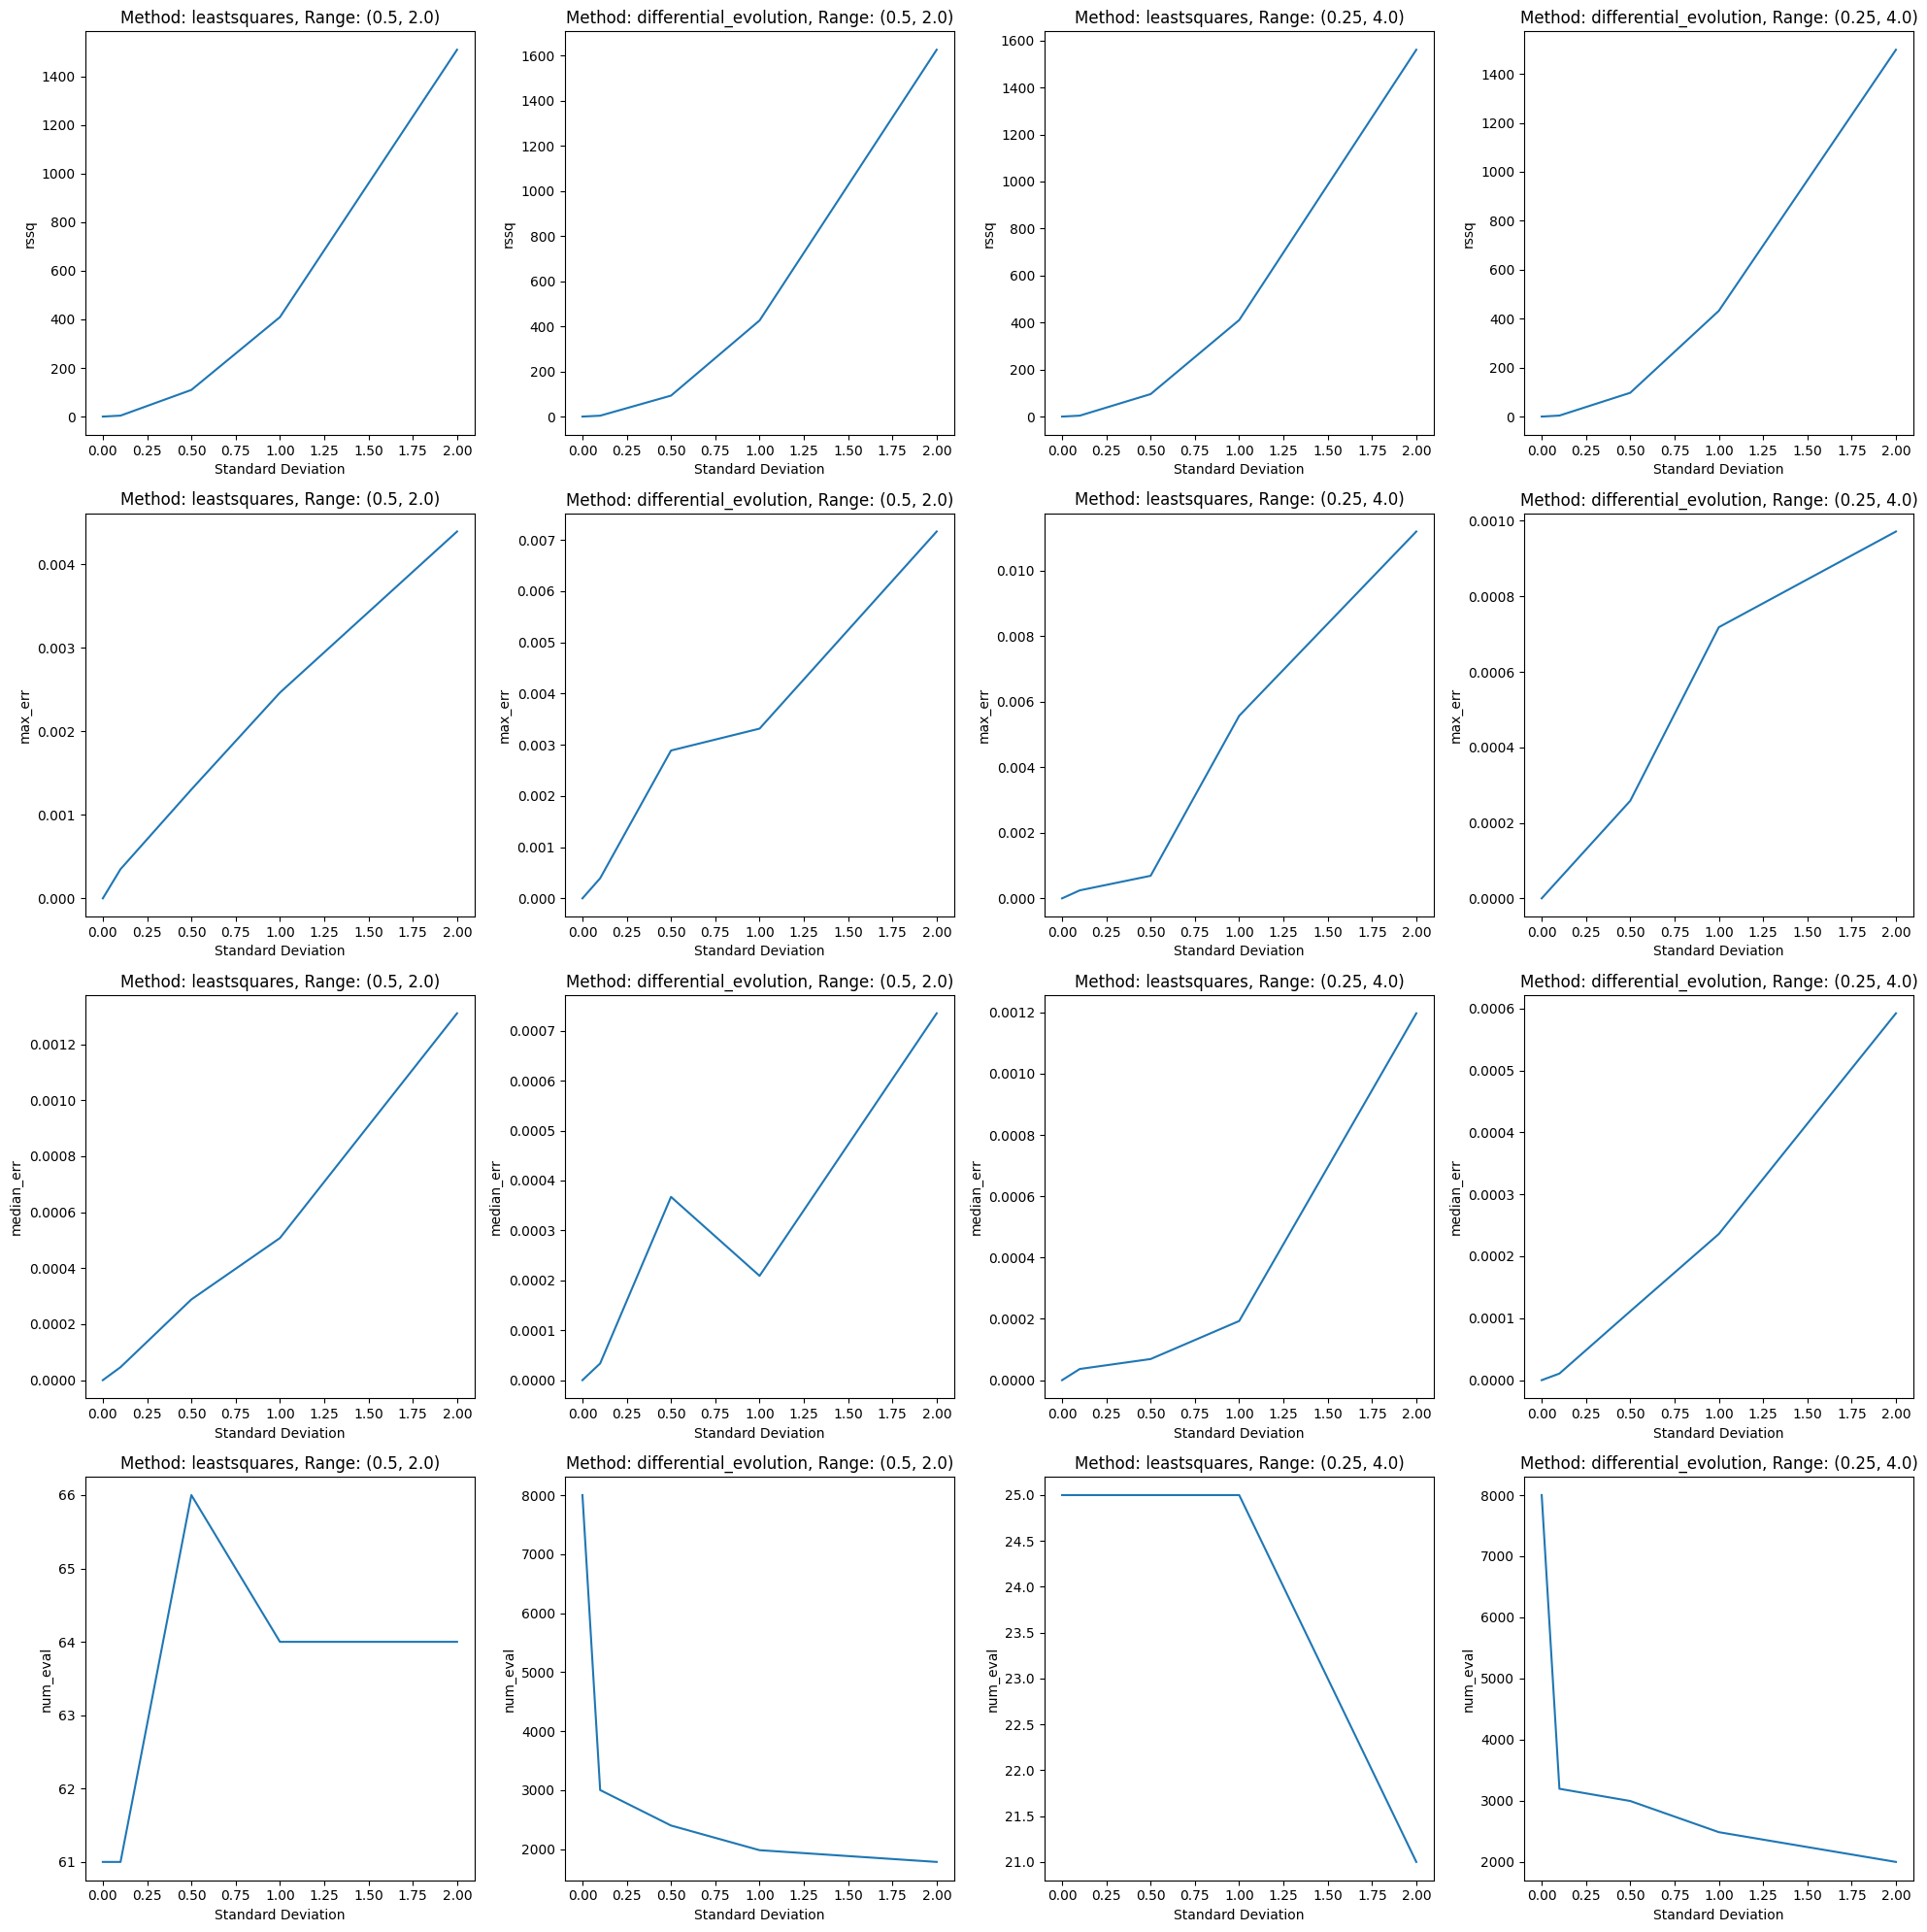

In [ ]:
import matplotlib.pyplot as plt

# Define the standard deviations and search ranges
std_devs = [0, 0.1, 0.5, 1.0, 2.0]
search_ranges = [(0.5, 2.0), (0.25, 4.0)]
methods = ['leastsquares', 'differential_evolution']
errors = ['rssq', 'max_err', 'median_err', 'num_eval']

# Initialize a figure
fig, axs = plt.subplots(len(errors), len(search_ranges)*len(methods), figsize=(20, 20))

for i, error in enumerate(errors):
    for j, (lower_frac, upper_frac) in enumerate(search_ranges):
        for k, method in enumerate(methods):
            error_values = []

            for std_dev in std_devs:
                # Fit the model
                fitter_info = doFit(model, std_dev, method, lower_frac, start_frac=lower_frac, upper_frac=upper_frac)

                # Store the error value
                error_values.append(getattr(fitter_info, error))

            # Plot the results
            ax = axs[i, j*len(methods) + k]
            ax.plot(std_devs, error_values)
            ax.set_xlabel('Standard Deviation')
            ax.set_ylabel(error)
            ax.set_title(f'Method: {method}, Range: ({lower_frac}, {upper_frac})')

plt.subplots_adjust(wspace=0.8, hspace=1.0)
plt.tight_layout()
plt.show()


# Which algorithm (leastsquares or differential_evolution) works best for these data and why?

Based on the data, the leastsquares search algorithin worked better. This is seen when comparing the number of evalutions between both search algorithims. The differential_evolution search algorithim had a number of evaluations in the 8000s where the leassquares algorithim had less than 70.


#Why are the maximum error and median error higher for the search range (0.25, 4.0) compared with (0.5, 2.0)?

The maximum error and median error are higher for the search range (0.25, 4.0) compared to (0.5, 2.0) because the wider search range includes more potential parameter values that the fitting algorithm needs to consider.

In the context of model fitting, the search range defines the space within which the algorithm looks for the optimal parameters that best fit the data. A wider search range means a larger space and therefore more potential solutions. This can lead to higher errors if the optimal solution lies outside the narrower range.

#Why does the residual sum of squares (RSSQ) increase with standard deviation?

When you increase the standard deviation, you’re essentially adding more noise to your data. This noise can cause the observed data to deviate more from the true underlying model. As a result, the discrepancies between the model’s predictions and the observed data (i.e., the residuals) can become larger. When these larger residuals are squared and summed to compute the RSSQ, the result is a larger RSSQ value.

#Why does do estimation errors (max_err and median_err) increase from standard deviation of 0 to non-zero standard deviations?

Estimation errors increase from a standard deviation of 0 to non-zero because noise is added to the data. This noise causes the data to deviate from the model, making it harder to estimate the model parameters accurately, leading to higher errors. In essence, noise introduces uncertainty, resulting in higher estimation errors.

